Урок3. Связь бизнес-показателей и DS-метрик

### Кейс 2 - определение ССЗ

ссылка на соревнование - https://mlbootcamp.ru/ru/round/12/sandbox/

В рамках конкурса вам нужно предсказать наличие сердечно-сосудистых заболеваний по результатам классического врачебного осмотра. Датасет сформирован из 100.000 реальных клинических анализов, и в нём используются признаки, которые можно разбить на 3 группы:

 

Объективные признаки:

 - Возраст
 - Рост
 - Вес
 - Пол
 

Результаты измерения:

 - Артериальное давление верхнее и нижнее
 - Холестерин
 - Глюкоза
 

Субъективные признаки:

 - Курение
 - Употребление Алкоголя
 - Физическая активность
 

Возраст дан в днях. Значения показателей холестерина и глюкозы представлены одним из трех классов: норма, выше нормы, значительно выше нормы. Значения субъективных признаков — бинарны.

Все показатели даны на момент осмотра.

Таргет - наличие сердечно-сосудистых заболеваний (ССЗ)

In [1100]:
import numpy as np
import pandas as pd
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, confusion_matrix, r2_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import cross_val_score, train_test_split
from scipy.sparse import hstack
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [9]:
df = pd.read_csv('train_case2.csv', ';')
df.head(3)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1


In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   age          70000 non-null  int64  
 2   gender       70000 non-null  int64  
 3   height       70000 non-null  int64  
 4   weight       70000 non-null  float64
 5   ap_hi        70000 non-null  int64  
 6   ap_lo        70000 non-null  int64  
 7   cholesterol  70000 non-null  int64  
 8   gluc         70000 non-null  int64  
 9   smoke        70000 non-null  int64  
 10  alco         70000 non-null  int64  
 11  active       70000 non-null  int64  
 12  cardio       70000 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 6.9 MB


In [55]:
# Пропусков нет
# Проверим, что у нас есть в полях
df.describe()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
count,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
mean,49972.419900,19468.865814,1.349571,164.359229,74.205690,128.817286,96.630414,1.366871,1.226457,0.088129,0.053771,0.803729,0.499700
std,28851.302323,2467.251667,0.476838,8.210126,14.395757,154.011419,188.472530,0.680250,0.572270,0.283484,0.225568,0.397179,0.500003
min,0.000000,10798.000000,1.000000,55.000000,10.000000,-150.000000,-70.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,25006.750000,17664.000000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,50001.500000,19703.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,74889.250000,21327.000000,2.000000,170.000000,82.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,99999.000000,23713.000000,2.000000,250.000000,200.000000,16020.000000,11000.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000


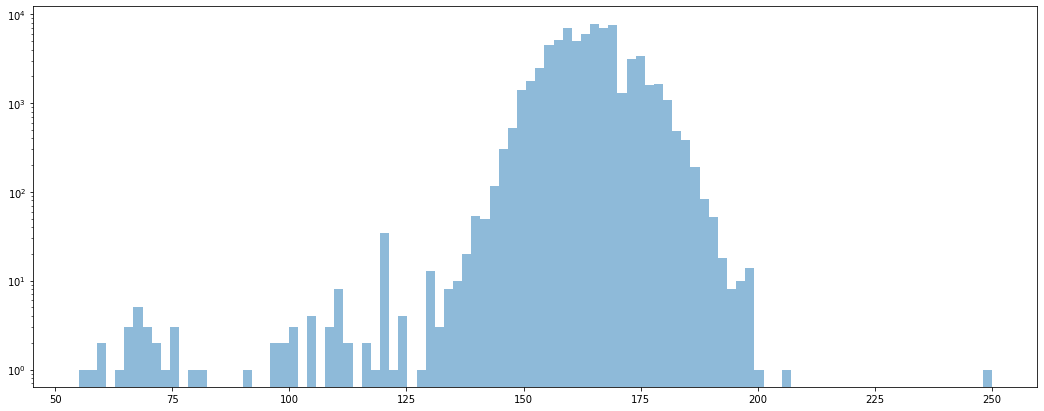

In [64]:
# В глаза бросаются возможные выбросы в height, weight и обоих давлениях
plt.figure(figsize=(18,7))
plt.hist(df.height, bins=100, log=True, alpha=0.5)
plt.draw()
# Распределение роста

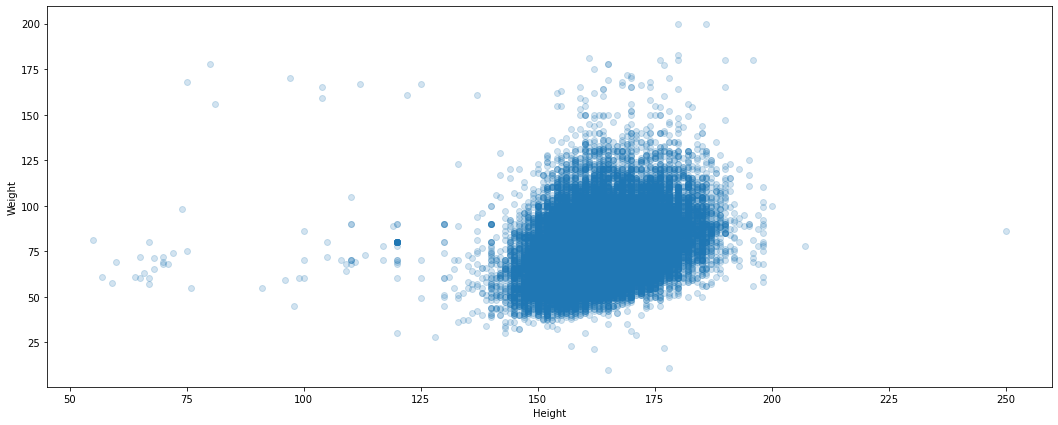

In [50]:
# Явно 250см рост - это перебор, но посмотрим их с весом
plt.figure(figsize=(18,7))
plt.scatter(df.height, df.weight, alpha=0.2)
plt.ylabel('Weight')
plt.xlabel('Height')
plt.draw()

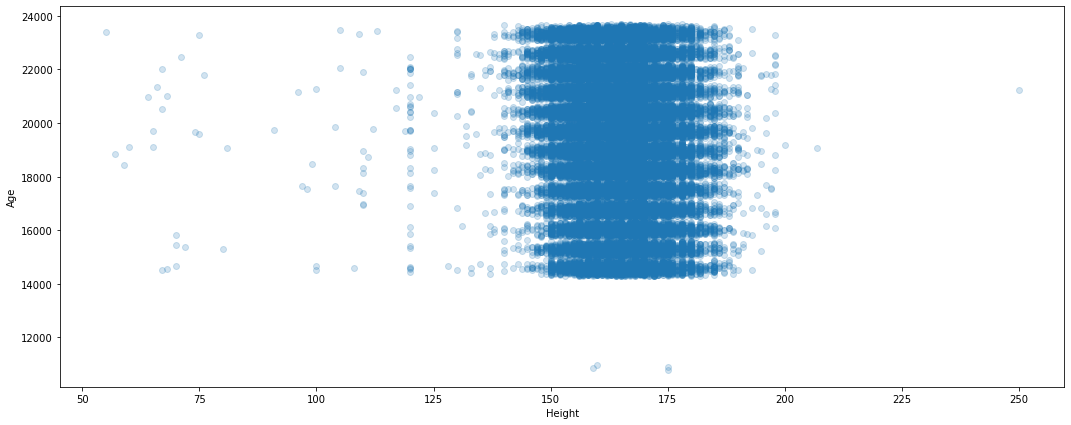

In [51]:
# Вобщем есть на земле такой человек, но вес его должен быть 137кг.. Здесь это явный выброс.
# Видимо стоит приводить в соответствие с весом. Как и выбросы в меньшую сторону рост < 100см
# Оценим их еще и вместе с возрастом
plt.figure(figsize=(18,7))
plt.scatter(df.height, df.age, alpha=0.2)
plt.ylabel('Age')
plt.xlabel('Height')
plt.draw()

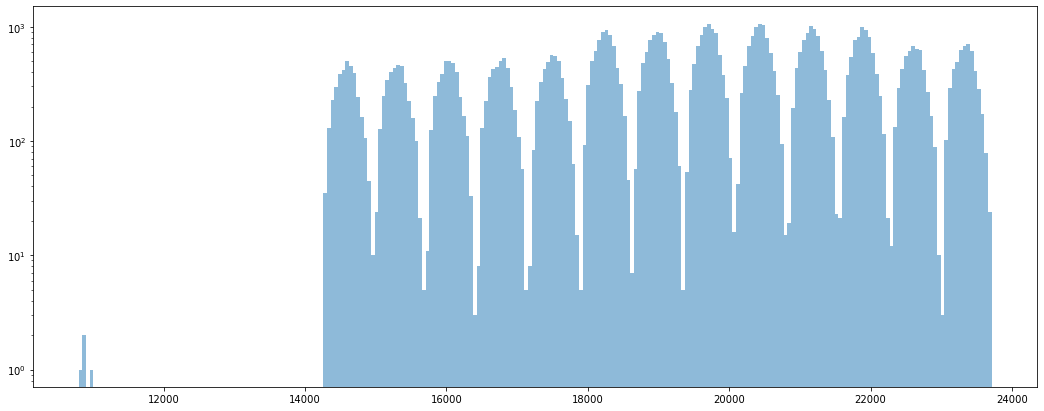

In [52]:
# Из этой взаимосвязанной друг с другом троицы рос-вес-возраст - 
# возраст выглядит наиболее правдоподобно:
plt.figure(figsize=(18,7))
plt.hist(df.age, bins=250, log=True, alpha=0.5)
plt.draw()

In [38]:
# Интересная картинка. Но жутко неудобно рассуждать о них как о днях. Переведем в года
def days_to_years(days):
    return days/365

df_age = df.copy()
df_age.age = df.age.apply(lambda x: days_to_years(x))
df_age.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,50.391781,2,168,62.0,110,80,1,1,0,0,1,0
1,1,55.419178,1,156,85.0,140,90,3,1,0,0,1,1
2,2,51.663014,1,165,64.0,130,70,3,1,0,0,0,1
3,3,48.282192,2,169,82.0,150,100,1,1,0,0,1,1
4,4,47.873973,1,156,56.0,100,60,1,1,0,0,0,0


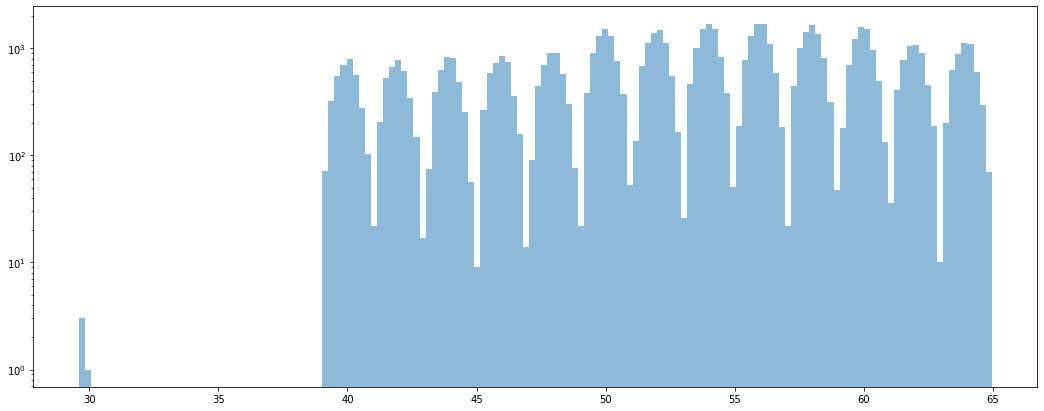

In [57]:
# Еще раз распределение:
plt.figure(figsize=(18,7))
plt.hist(df_age.age, bins=150, log=True, alpha=0.5)
plt.draw()

In [61]:
# Странные конечно группы (их 13) но тут ничего в голову не приходит.. 
# Есть мысль проверить самых молодых участников - основной возраст начинается с 38 - 
# но есть очень маленькая группа лиц меньше 30ти
df_age[df_age.age < 35]

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
6219,8850,29.802740,1,175,59.0,120,80,1,1,0,0,1,0
22343,31922,29.583562,2,175,92.0,100,60,1,1,0,0,1,0
30666,43842,29.750685,1,159,59.0,120,80,1,1,0,0,1,0
55905,79749,30.038356,1,160,59.0,110,70,1,1,0,0,1,0


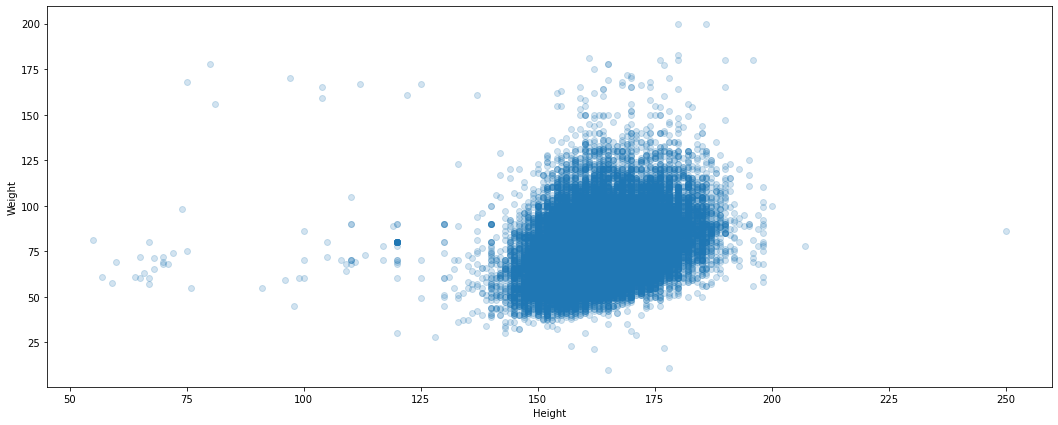

In [62]:
# Выглядит абсолютно пристойно всё у них - видимо это не выбросы
# Итак мы решили, что возраст у нас корректный.
# Возраст весь взрослый - соответственно на рост и вес значимого влияния он не должен оказывать
# Займемся весом и ростом.
plt.figure(figsize=(18,7))
plt.scatter(df.height, df.weight, alpha=0.2)
plt.ylabel('Weight')
plt.xlabel('Height')
plt.draw()

In [63]:
# У роста выброс вверх (один) и множество вниз (меньше 130см при весе 50 и выше выглядит не очень правдоподобно)
# У веса тоже судя по всему выбросы - но все внизу
# Будем пробовать восстанавлиавать их друг через друга

In [1325]:
# Отделим измерения с некорректным ростом
df_height_for_pred = df.loc[(df.height > 210) | (df.height < 140)]
df_height_for_pred.shape

(153, 13)

In [1326]:
df_height_for_pred.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
224,309,21800,2,76,55.0,120,80,1,1,0,0,1,0
2412,3399,22629,2,138,52.0,140,100,1,1,0,0,1,1
2944,4150,19591,1,134,52.0,120,70,1,1,0,0,0,0
3208,4523,18285,1,136,57.0,120,80,1,1,0,0,1,0
3420,4838,14516,1,100,70.0,100,70,1,1,0,0,1,0


In [434]:
# Тренировочная выборка для нас должна быть с максимально правдоподобными диапазонами роста и веса
df_height = df.loc[(df.height <= 190) & (df.height >= 145) & (df.weight > 40) & (df.weight < 120)]
df_height.shape

(68902, 13)

In [450]:
# Попробуем визуализировать зависимости роста и веса от других факторов (пола, холестерина)
df_height_man = df_height.loc[df_height.gender == 2]
df_height_woman = df_height.loc[df_height.gender == 1]
df_height_cholesterol = df_height.loc[df_height.cholesterol == 3]

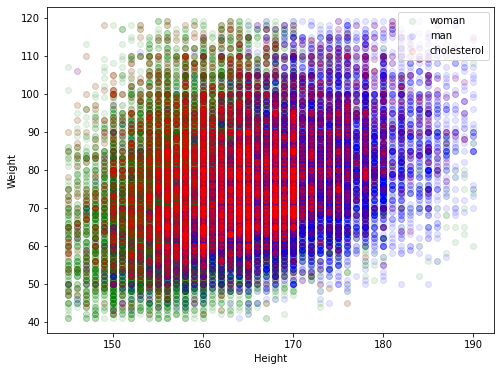

In [452]:
plt.figure(figsize=(8,6))
plt.scatter(df_height_woman.height, df_height_woman.weight, alpha=0.1, color='green', label='woman')
plt.scatter(df_height_man.height, df_height_man.weight, alpha=0.1, color='blue', label='man')
plt.scatter(df_height_cholesterol.height, df_height_cholesterol.weight, alpha=0.1, color='red', label='cholesterol')
plt.ylabel('Weight')
plt.xlabel('Height')
plt.legend(loc='upper right')
plt.draw()

In [453]:
# Вобщем холестерин на вес или рост никак особо не влияет похоже. А вот пол влияет..

In [603]:
# Сделаем пайплайн для этого этапа
class OHE_encoder(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        result = X.copy()
        for column in self.columns:
            result[column] = result[column].apply(str)
        one_hots = pd.get_dummies(result[self.columns])
        return result.drop(self.columns, axis=1).merge(one_hots, left_index=True, right_index=True)

In [570]:
class Scaler(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        scaler = StandardScaler()
        X[self.columns] = scaler.fit_transform(X[self.columns])
        return X

In [805]:
class Group_by_features(BaseEstimator, TransformerMixin):
    def __init__(self, group_by, column, method):
        self.group_by = group_by
        self.column = column
        self.method = method
        self.new_column = '{}_{}'.format(group_by, column)

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        result = X.copy()
        result[self.new_column] = result.groupby(self.group_by)[self.column].transform('median')
        return result

In [806]:
class Offset_from_center(BaseEstimator, TransformerMixin):
    def __init__(self, column, method):
        self.column = column
        self.method = method
        self.new_column = '{}_offset'.format(column)

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        result = X.copy()
        result[self.new_column] = self.method(result[self.column]) - result[self.column]
        return result

In [874]:
class Drop_nonrelated_column(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        result = X.copy()
        result.drop(self.column, axis=1, inplace=True)
        return result

In [875]:
def prepare_test(df, target):
    test_df = df.copy()
    test_df.reset_index(inplace=True)
    X = test_df.drop([target], axis=1)
    y = pd.Series(test_df[target].values)
    return X, y

In [899]:
height_feats = Pipeline([
    # ('delete_nonrelated', Drop_nonrelated_column('id')),
    ('gender_weight', Group_by_features(group_by='gender', column='weight', method=np.median)),
    ('weight_offset', Offset_from_center(column='gender', method=np.mean)),
    ('ohe', OHE_encoder(['gender', 'cholesterol', 'gluc'])),
    ('scaler', Scaler(['weight', 'gender_weight'])),
])

In [900]:
def get_height_predictor(model):
    return Pipeline([
        ('features_for_height', height_feats),
        ('classifier', model)
    ])

In [901]:
# X, y = prepare_test(df_height, 'height')
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=0)
# height_predictor_lr = get_height_predictor(LinearRegression())
# height_predictor_lr.transform(X_train)

In [902]:
X, y = prepare_test(df_height.drop('cardio', axis=1), 'height')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=0)
height_predictor_lr = get_height_predictor(LinearRegression())

#запустим кросс-валидацию
cv_scores = cross_val_score(height_predictor_lr, X_train, y_train, cv=16, scoring='r2')
cv_score = np.mean(cv_scores)
cv_score_std = np.std(cv_scores)
print('CV score is {}+-{}'.format(cv_score, cv_score_std))

CV score is 0.33983419029841866+-0.01633078122903726


In [887]:
# Тухленько, но это и понятно наверное, рост не имеет линейной зависимости ни от чего
# Попробуем "деревянные" модели
X, y = prepare_test(df_height.drop('cardio', axis=1), 'height')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=0)
height_predictor_rf = get_height_predictor(RandomForestRegressor())
cv_scores = cross_val_score(height_predictor_rf, X_train, y_train, cv=16, scoring='r2')
cv_score = np.mean(cv_scores)
cv_score_std = np.std(cv_scores)
print('CV score is {}+-{}'.format(cv_score, cv_score_std))

CV score is 0.3424985419339851+-0.014060563845618565


In [891]:
# деревья слишком глубокие получаются или их много?
height_predictor_rf = get_height_predictor(RandomForestRegressor(max_depth=6, n_estimators=150))
cv_scores = cross_val_score(height_predictor_rf, X_train, y_train, cv=16, scoring='r2')
cv_score = np.mean(cv_scores)
cv_score_std = np.std(cv_scores)
print('CV score is {}+-{}'.format(cv_score, cv_score_std))

CV score is 0.38610812545221745+-0.013759669605823647


In [903]:
# Окей, остановимся на случайном лесе. 
# В конце концов это предсказание небольшого количества выбросов, 
# которое в противном случае мы бы просто заменили каким нибудь средним..
height_predictor_rf = get_height_predictor(RandomForestRegressor(max_depth=6, n_estimators=150))
height_predictor_rf.fit(X_train, y_train)

Pipeline(steps=[('features_for_height',
                 Pipeline(steps=[('gender_weight',
                                  Group_by_features(column='weight',
                                                    group_by='gender',
                                                    method=<function median at 0x7ff18172e5e0>)),
                                 ('weight_offset',
                                  Offset_from_center(column='gender',
                                                     method=<function mean at 0x7ff1814cb790>)),
                                 ('ohe',
                                  OHE_encoder(columns=['gender', 'cholesterol',
                                                       'gluc'])),
                                 ('scaler',
                                  Scaler(columns=['weight',
                                                  'gender_weight']))])),
                ('classifier',
                 RandomForestRegressor(max_depth=6, n_esti

In [904]:
y_pred = height_predictor_rf.predict(X_test)
r2_score(y_test, y_pred)

0.3892072826799775

In [1328]:
# Ожидаемо. Теперь предскажем те значения ради которых мы это и делали
y_real_heights = height_predictor_rf.predict(df_height_for_pred.drop('cardio', axis=1))
df_height_for_pred['height'] = pd.Series(y_real_heights).values
df_height_for_pred

<ipython-input-1328-09f0f7c0f035>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_height_for_pred['height'] = pd.Series(y_real_heights).values


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
224,309,21800,2,167.498061,55.0,120,80,1,1,0,0,1,0
2412,3399,22629,2,167.195791,52.0,140,100,1,1,0,0,1,1
2944,4150,19591,1,161.739995,52.0,120,70,1,1,0,0,0,0
3208,4523,18285,1,164.263076,57.0,120,80,1,1,0,0,1,0
3420,4838,14516,1,162.714527,70.0,100,70,1,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
66479,94906,16928,2,172.921690,90.0,110,90,1,1,0,0,1,0
66643,95141,18830,1,162.511651,61.0,130,90,1,1,0,0,1,1
67866,96921,21763,1,161.303477,123.0,180,100,2,1,0,0,1,1
69052,98630,20401,2,170.992862,80.0,140,90,1,2,0,0,1,1


In [914]:
# Вернем их в датасет
df_height_for_pred.height = pd.Series(y_real_heights).values
df_height_for_pred

/Users/postas/Anaconda/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
224,309,21800,2,167.498061,55.0,120,80,1,1,0,0,1,0
2412,3399,22629,2,167.195791,52.0,140,100,1,1,0,0,1,1
2944,4150,19591,1,161.739995,52.0,120,70,1,1,0,0,0,0
3208,4523,18285,1,164.263076,57.0,120,80,1,1,0,0,1,0
3420,4838,14516,1,162.714527,70.0,100,70,1,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
66479,94906,16928,2,172.921690,90.0,110,90,1,1,0,0,1,0
66643,95141,18830,1,162.511651,61.0,130,90,1,1,0,0,1,1
67866,96921,21763,1,161.303477,123.0,180,100,2,1,0,0,1,1
69052,98630,20401,2,170.992862,80.0,140,90,1,2,0,0,1,1


In [981]:
# Хорошо. Теперь запакуем всю эту конструкцию в свой этап пайплайна (подготовка height)
class Predict_height(BaseEstimator, TransformerMixin):
    def __init__(self, predict_pipeline):
        self.pipeline = predict_pipeline

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # Отделим измерения с некорректным ростом
        df_height_for_pred = X.loc[(X.height > 210) | (X.height < 140)]
        # Предскажем для них значения height с помощью предоставленного пайплайна
        y_real_heights = self.pipeline.predict(df_height_for_pred)
        # Вернем их в датасет
        df_height_for_pred.height = pd.Series(y_real_heights).values
        # Совместим с теми измерениями в которых мы height не предсказывали 
        # (в которых он нас устраивал)
        result = X.loc[(X.height <= 210) & (X.height >= 140)]
        result = result.append(df_height_for_pred)
        return result.sort_index()

In [982]:
# Обкатаем теперь целиковый пайплайн
fix_bad_height = Pipeline([('predict_height', Predict_height(predict_pipeline=height_predictor_rf))])

In [985]:
df_fixed_height = fix_bad_height.transform(df.drop('cardio', axis=1))
df_fixed_height.head()

/Users/postas/Anaconda/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active
0,0,18393,2,168.0,62.0,110,80,1,1,0,0,1
1,1,20228,1,156.0,85.0,140,90,3,1,0,0,1
2,2,18857,1,165.0,64.0,130,70,3,1,0,0,0
3,3,17623,2,169.0,82.0,150,100,1,1,0,0,1
4,4,17474,1,156.0,56.0,100,60,1,1,0,0,0


In [1011]:
# Отлично, что-то получилось. 
# Время теперь заняться неправильным весом
# Отделим измерения с некорректным весом
df_weight_for_pred = df_fixed_height.loc[(df_fixed_height.weight > 190) | (df_fixed_height.weight < 35)]
df_weight_for_pred.shape

(22, 12)

In [1019]:
# И снова - для тренировки модели - нам понадобится подвыборка с наиболее адекватным
# диапазоном ростов и весов
df_weights = df_fixed_height.loc[(df_fixed_height.weight < 180) & (df_fixed_height.weight > 45) \
                    & (df_fixed_height.height > 145) & (df_fixed_height.height < 200)]
df_weights.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active
0,0,18393,2,168.0,62.0,110,80,1,1,0,0,1
1,1,20228,1,156.0,85.0,140,90,3,1,0,0,1
2,2,18857,1,165.0,64.0,130,70,3,1,0,0,0
3,3,17623,2,169.0,82.0,150,100,1,1,0,0,1
4,4,17474,1,156.0,56.0,100,60,1,1,0,0,0


In [1078]:
weight_feats = Pipeline([
    # ('delete_nonrelated_h', Drop_nonrelated_column('ap_hi')),
    # ('delete_nonrelated_l', Drop_nonrelated_column('ap_lo')),
    # ('delete_nonrelated_i', Drop_nonrelated_column('id')),
    ('gender_height', Group_by_features(group_by='gender', column='height', method=np.median)),
    ('height_offset', Offset_from_center(column='gender', method=np.mean)),
    ('ohe', OHE_encoder(['gender', 'cholesterol', 'gluc'])),
    ('scaler', Scaler(['height', 'gender_height', 'ap_hi', 'ap_lo'])),
])

In [1079]:
def get_weight_predictor(model):
    return Pipeline([
        ('features_for_weight', weight_feats),
        ('classifier', model)
    ])

In [1080]:
# X, y = prepare_test(df_weights, 'weight')
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=0)
# weight_predictor_lr = get_weight_predictor(LinearRegression())
# weight_predictor_lr.transform(X_train)

In [1081]:
X, y = prepare_test(df_weights, 'weight')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=0)
weight_predictor_lr = get_weight_predictor(LinearRegression())

#запустим кросс-валидацию
cv_scores = cross_val_score(weight_predictor_lr, X_train, y_train, cv=16, scoring='r2')
cv_score = np.mean(cv_scores)
cv_score_std = np.std(cv_scores)
print('CV score is {}+-{}'.format(cv_score, cv_score_std))

CV score is 0.13053716895958956+-0.012727219369879146


In [1082]:
# Жесть, я думал при предсказании роста была плохая метрика )
weight_predictor_rf = get_weight_predictor(RandomForestRegressor(max_depth=6, n_estimators=150))
cv_scores = cross_val_score(weight_predictor_rf, X_train, y_train, cv=16, scoring='r2')
cv_score = np.mean(cv_scores)
cv_score_std = np.std(cv_scores)
print('CV score is {}+-{}'.format(cv_score, cv_score_std))

CV score is 0.16923877149627603+-0.021580401561517817


In [1083]:
# Окей, ради 22-х измерений сейчас нет готовности добиваться чего-то запредельного
weight_predictor_rf = get_weight_predictor(RandomForestRegressor(max_depth=6, n_estimators=150))
weight_predictor_rf.fit(X_train, y_train)

Pipeline(steps=[('features_for_weight',
                 Pipeline(steps=[('gender_height',
                                  Group_by_features(column='height',
                                                    group_by='gender',
                                                    method=<function median at 0x7ff18172e5e0>)),
                                 ('height_offset',
                                  Offset_from_center(column='gender',
                                                     method=<function mean at 0x7ff1814cb790>)),
                                 ('ohe',
                                  OHE_encoder(columns=['gender', 'cholesterol',
                                                       'gluc'])),
                                 ('scaler',
                                  Scaler(columns=['height', 'gender_height',
                                                  'ap_hi', 'ap_lo']))])),
                ('classifier',
                 RandomForestRegressor(m

In [1084]:
y_pred = weight_predictor_rf.predict(X_test)
r2_score(y_test, y_pred)

0.19308011089256405

In [1085]:
# Ок. Теперь предскажем те значения ради которых мы это и делали
y_real_weights = weight_predictor_rf.predict(df_weight_for_pred)

In [1086]:
# Вернем их в датасет
df_weight_for_pred.weight = pd.Series(y_real_weights).values
df_weight_for_pred

/Users/postas/Anaconda/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active
435,618,16765,1,186.000000,87.026001,130,70,1,1,0,0,0
3752,5306,15400,1,158.472184,75.883169,110,70,1,1,0,0,1
14722,21040,22663,1,143.000000,76.047627,100,70,1,1,0,0,1
16906,24167,17272,2,170.000000,101.547894,150,90,2,2,0,0,1
18559,26503,18140,1,160.000000,77.706925,120,80,1,1,0,0,1
22016,31439,15359,1,146.000000,76.047627,100,70,1,1,0,0,0
26806,38312,23284,1,157.000000,76.189179,110,80,1,1,0,0,1
29488,42156,20408,2,177.000000,78.717311,120,80,1,1,1,1,1
33511,47872,21081,1,153.000000,81.807810,110,70,3,3,0,0,1
33817,48318,21582,2,178.000000,93.560227,130,90,1,1,0,0,1


In [1089]:
# Чушь какую-то предсказывает как по мне.. )

In [1091]:
# Запаковываем.. тем не менее
# Хорошо. Теперь запакуем всю эту конструкцию в свой этап пайплайна (подготовка height)
class Predict_weight(BaseEstimator, TransformerMixin):
    def __init__(self, predict_pipeline):
        self.pipeline = predict_pipeline

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # Отделим измерения с некорректным весом
        df_weight_for_pred = df_fixed_height.loc[(df_fixed_height.weight > 190) | (df_fixed_height.weight < 35)]
        # Предскажем для них значения height с помощью предоставленного пайплайна
        y_real_weights = self.pipeline.predict(df_weight_for_pred)
        # Вернем их в датасет
        df_weight_for_pred.weight = pd.Series(y_real_weights).values
        # Совместим с теми измерениями в которых мы weight не предсказывали 
        # (в которых он нас устраивал)
        result = X.loc[(X.weight <= 190) & (X.weight >= 35)]
        result = result.append(df_weight_for_pred)
        return result.sort_index()

In [1092]:
# Тестируем пайплайн поправок по weight
fix_bad_weight = Pipeline([('predict_weight', Predict_weight(predict_pipeline=weight_predictor_rf))])

In [1175]:
df_fixed_weight = fix_bad_weight.transform(df_fixed_height)
df_fixed_weight.head()

/Users/postas/Anaconda/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active
0,0,18393,2,168.0,62.0,110,80,1,1,0,0,1
1,1,20228,1,156.0,85.0,140,90,3,1,0,0,1
2,2,18857,1,165.0,64.0,130,70,3,1,0,0,0
3,3,17623,2,169.0,82.0,150,100,1,1,0,0,1
4,4,17474,1,156.0,56.0,100,60,1,1,0,0,0


### Думаю экспериментов с пайплайнами достаточно
### Сделаем ДЗ

In [1240]:
# Нам потребуется обучить несколько моделей на обработанном нами датасете 
# и сделать выводы об их эффективности

def get_final_pipeline(model):
    return Pipeline([
        ('fix_height', fix_bad_height),
        ('fix_weight', fix_bad_weight),
        ('scaler', Scaler(['height', 'weight', 'ap_hi', 'ap_lo', 'age'])),
        ('classifier', model)
    ])

In [1241]:
lr_pipeline = get_final_pipeline(LogisticRegression())
gb_pipeline = get_final_pipeline(GradientBoostingClassifier())
rf_pipeline = get_final_pipeline(RandomForestClassifier())

In [1237]:
def prepare_data(df, target):
    data_df = df.copy()
    X = data_df.drop([target], axis=1)
    y = pd.Series(data_df[target].values)
    return X, y

In [1291]:
X, y = prepare_data(df, 'cardio')

In [1244]:
# Учить будем на всем датасете - все равно это только для скора
# Запустим кросс-валидацию
cv_scores = cross_val_score(lr_pipeline, X, y, cv=16, scoring='f1')
cv_score = np.mean(cv_scores)
cv_score_std = np.std(cv_scores)
print('CV score is {}+-{}'.format(cv_score, cv_score_std))

CV score is nan+-nan


/Users/postas/Anaconda/anaconda3/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '
/Users/postas/Anaconda/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/postas/Anaconda/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/postas/Anaconda/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 330, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/Users/postas/Anaconda/anaconda3/lib/python3.8/site-packages/sklearn

### Провозился с этой проблемой неведомое количество времени - так и не понял в чем дело
Кросс валидаторы не хотят работать с таким пайплайном ни в какую. 
При этом fit, predict, predict_proba на нем отрабатывают норм...
Будем делать вручную - трансформить данные, и дальше отдельно их гонять в кросс-валидации

In [1245]:
prepare_features_lr = Pipeline([
    ('fix_height', fix_bad_height),
    ('fix_weight', fix_bad_weight),
    ('scaler', Scaler(['height', 'weight', 'ap_hi', 'ap_lo', 'age'])),
])

In [1246]:
prepare_features_trees = Pipeline([
    ('fix_height', fix_bad_height),
    ('fix_weight', fix_bad_weight)
])

In [1306]:
data_for_lr = prepare_features_lr.transform(X)
data_for_lr.head()

/Users/postas/Anaconda/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/Users/postas/Anaconda/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active
0,0,-0.436062,2,0.452791,-0.850844,-0.122182,-0.088238,1,1,0,0,1
1,1,0.307686,1,-1.084290,0.750809,0.072610,-0.035180,3,1,0,0,1
2,2,-0.247997,1,0.068521,-0.711570,0.007679,-0.141297,3,1,0,0,0
3,3,-0.748152,2,0.580881,0.541898,0.137541,0.017879,1,1,0,0,1
4,4,-0.808543,1,-1.084290,-1.268667,-0.187113,-0.194356,1,1,0,0,0


In [1307]:
# Для "деревянных" не будем стандартизировать значения
data_for_trees = prepare_features_trees.transform(X)
data_for_trees.head()

/Users/postas/Anaconda/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/Users/postas/Anaconda/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active
0,0,18393,2,168.0,62.0,110,80,1,1,0,0,1
1,1,20228,1,156.0,85.0,140,90,3,1,0,0,1
2,2,18857,1,165.0,64.0,130,70,3,1,0,0,0
3,3,17623,2,169.0,82.0,150,100,1,1,0,0,1
4,4,17474,1,156.0,56.0,100,60,1,1,0,0,0


In [1308]:
lr = LogisticRegression()
rf = RandomForestClassifier()
gb = GradientBoostingClassifier()

In [1253]:
# Запустим кросс-валидацию
cv_scores = cross_val_score(lr, data_for_lr, y, cv=16, scoring='f1')
cv_score = np.mean(cv_scores)
cv_score_std = np.std(cv_scores)
print('CV score is {}+-{}'.format(cv_score, cv_score_std))

CV score is 0.6470358992618267+-0.036697881243506834


In [1255]:
cv_scores = cross_val_score(rf, data_for_trees, y, cv=16, scoring='f1')
cv_score = np.mean(cv_scores)
cv_score_std = np.std(cv_scores)
print('CV score is {}+-{}'.format(cv_score, cv_score_std))

CV score is 0.7003532916139984+-0.06832157481478572


In [1256]:
cv_scores = cross_val_score(gb, data_for_trees, y, cv=16, scoring='f1')
cv_score = np.mean(cv_scores)
cv_score_std = np.std(cv_scores)
print('CV score is {}+-{}'.format(cv_score, cv_score_std))

CV score is 0.6810945619877722+-0.1743311251921832


In [1309]:
# Тэкс.. лидирует случайный лес - теперь статистика
def stats(y, preds):
    precision, recall, thresholds = precision_recall_curve(y, preds)
    fscore = (2 * precision * recall) / (precision + recall)
    ix = np.argmax(fscore)
    return fscore[ix], precision[ix], recall[ix], roc_auc_score(y, preds)

In [1310]:
X_lr_train, X_lr_test, y_lr_train, y_lr_test = train_test_split(data_for_lr, y, test_size=0.33, shuffle=True, random_state=0)
lr.fit(X_lr_train, y_lr_train)
lr_result = lr.predict_proba(X_lr_test)[:, 1]

In [1298]:
X_rf_train, X_rf_test, y_rf_train, y_rf_test = train_test_split(data_for_trees, y, test_size=0.33, shuffle=True, random_state=0)
rf.fit(X_rf_train, y_rf_train)
rf_result = rf.predict_proba(X_rf_test)[:, 1]

In [1299]:
X_gb_train, X_gb_test, y_gb_train, y_gb_test = train_test_split(data_for_trees, y, test_size=0.33, shuffle=True, random_state=0)
gb.fit(X_gb_train, y_gb_train)
gb_result = gb.predict_proba(X_gb_test)[:, 1]

In [1312]:
precision, recall, thresholds = precision_recall_curve(y_lr_test, lr_result)
fscore = (2 * precision * recall) / (precision + recall)
ix = np.argmax(fscore)
ix, fscore[ix], precision[ix], recall[ix], roc_auc_score(y_lr_test, lr_result)

<ipython-input-1312-799c9a82ca98>:2: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)


(23098, nan, 0.0, 0.0, 0.498974520037657)

In [1300]:
rows = []
for (method, yy) in zip([lr_result, rf_result, gb_result], [y_lr_test, y_rf_test, y_gb_test]):
    rows.append(stats(yy, method))
table = pd.DataFrame(rows)
table.columns = ['fscore', 'precission', 'recall', 'roc_auc']
table['method'] = ['LogReg', 'RandTree', 'GradBoost']
table = table[['method'] + ['fscore', 'precission', 'recall', 'roc_auc']]
table

<ipython-input-1282-9c39d6ffdf5c>:4: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)
<ipython-input-1282-9c39d6ffdf5c>:4: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)


,method,fscore,precission,recall,roc_auc
0,LogReg,NaN,0.000000,0.000000,0.498975
1,RandTree,0.729458,0.664598,0.808346,0.785254
2,GradBoost,NaN,0.000000,0.000000,0.803457


In [1313]:
# Зашибись - не может с этой выборкой даже precision_recall_curve справиться...
X, y = prepare_data(df, 'cardio')
X_lr_train, X_lr_test, y_lr_train, y_lr_test = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=0)
lr.fit(X_lr_train, y_lr_train)
lr_result = lr.predict_proba(X_lr_test)[:, 1]

X_rf_train, X_rf_test, y_rf_train, y_rf_test = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=0)
rf.fit(X_rf_train, y_rf_train)
rf_result = rf.predict_proba(X_rf_test)[:, 1]

X_gb_train, X_gb_test, y_gb_train, y_gb_test = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=0)
gb.fit(X_gb_train, y_gb_train)
gb_result = gb.predict_proba(X_gb_test)[:, 1]

In [1316]:
rows = []
for (method, yy) in zip([lr_result, rf_result, gb_result], [y_lr_test, y_rf_test, y_gb_test]):
    rows.append(stats(yy, method))
table = pd.DataFrame(rows)
table.columns = ['fscore', 'precission', 'recall', 'roc_auc']
table['method'] = ['LogReg', 'RandTree', 'GradBoost']
table = table[['method'] + ['fscore', 'precission', 'recall', 'roc_auc']]
table

,method,fscore,precission,recall,roc_auc
0,LogReg,0.710667,0.612707,0.845914,0.756014
1,RandTree,0.728167,0.670414,0.796807,0.785198
2,GradBoost,0.743635,0.688516,0.808346,0.803229


## По сырой выборке результаты - GradientBoosting лучше всего работает, RandomTree на втором месте, LogReg - на последнем